In [ ]:
import os

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.adamw import AdamW

from utils import BatchLoader, experiment, save, train_loop

In [ ]:
# hyperparameters
batch_size = 16 
block_size = 128  # maximum context length
max_iters = 1000
eval_interval = 200
learning_rate = 3e-4
device = ("cuda" if torch.cuda.is_available() else "cpu")
)
eval_iters = 200
n_embd = 256
n_head = 4
n_blocks = 4
dropout = 0.2

torch.manual_seed(1337)

In [ ]:
class Tokenizer:
    def __init__(self, chars: list[str]):
        self.stoi = {s: i for i, s in enumerate(chars)}
        self.itos = {v: k for k, v in self.stoi.items()}

    def encode(self, text: str) -> list[int]:
        return [self.stoi[c] for c in text]

    def decode(self, ixs: list[int]) -> str:
        return "".join([self.itos[ix] for ix in ixs])

In [ ]:
class Head(nn.Module):
    #one head of self-attention

    def __init__(self, head_size, n_embd, block_size, dropout=0.2):
        super().__init__()
        self.head_size = head_size
        self.key = nn.Linear(n_embd, head_size, bias=False)  # (head_size, n_embd)
        self.query = nn.Linear(n_embd, head_size, bias=False)  # (head_size, n_embd)
        self.value = nn.Linear(n_embd, head_size, bias=False)  # (head_size, n_embd)
        self.register_buffer("tril", torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B, T, C = x.shape

        k = self.key(x)  # (B, T, head_size)
        q = self.query(x)  # (B, T, head_size)

        wei = q @ k.transpose(-2, -1) * (self.head_size**-0.5)  # (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float("-inf"))
        wei = F.softmax(wei, dim=-1)  # (B,T,T)
        wei = self.dropout(wei)
        
        v = self.value(x)
        out = wei @ v  # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out


class MultiHeadAttentionConcat(nn.Module):
    #Implements multi-head self-attention using individual heads and concatenating their results at the end

    def __init__(self, num_heads, head_size, n_embd, device, block_size, dropout=0.2):
        super().__init__()
        self.num_heads = num_heads

        self.heads = nn.ModuleList(
            [Head(head_size, n_embd, block_size, dropout) for _ in range(num_heads)]
        )
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], -1)
        out = self.dropout(self.proj(out))
        return out


class MultiHeadAttention(nn.Module):
    #implements multi-headed masked self-attention

    def __init__(self, num_heads, head_size, n_embd, device, block_size, dropout=0.2):
        super().__init__()
        gen = torch.Generator(device=device)
        gen.manual_seed(42)

        self.num_heads = num_heads
        self.n_embd = n_embd
        self.device = device
        self.block_size = block_size
        self.dropout = dropout
        self.head_size = head_size

        key = (
            torch.randn(num_heads, n_embd, head_size, generator=gen, device=device)
            * (n_embd * num_heads) ** -0.5
        )
        query = (
            torch.randn(num_heads, n_embd, head_size, generator=gen, device=device)
            * (n_embd * num_heads) ** -0.5
        )
        value = (
            torch.randn(num_heads, n_embd, head_size, generator=gen, device=device)
            * (n_embd * num_heads) ** -0.5
        )

        self.key = nn.Parameter(key)
        self.query = nn.Parameter(query)
        self.value = nn.Parameter(value)

        self.proj = nn.Linear(n_embd, n_embd)

        self.dropout = nn.Dropout(dropout)

        # (B, T, n_embd) x (num_heads, n_embd, head_size) --> (B, num_heads, T, head_size)
        self.register_buffer(
            "tril", torch.tril(torch.ones(num_heads, block_size, block_size))
        )

    def forward(self, x):
        B, T, C = x.shape
        x = x.unsqueeze(1)  # (batch_size, 1, context_length, n_embd)
        k = x @ self.key  # (batch_size, num_heads, context_length, head_size)
        q = x @ self.query  # (batch_size, num_heads, context_length, head_size)

        wei = (
            q @ k.transpose(-2, -1) * (self.head_size**-0.5)
        )  # (bs, nh, cl, hs) x (bs, nh, hs, cl) -> (bs, nh, cl, cl)
        wei = wei.masked_fill(self.tril[:, :T, :T] == 0, float("-inf"))
        wei = F.softmax(wei, dim=-1)  # (bs, nh, cl, cl)

        v = x @ self.value  # (bs, 1, cl, ne) x (nh, ne, hs) -> (bs, nh, cl, hs)
        out = wei @ v  # (bs, nh, cl, cl) x (bs, nh, cl, hs) -> (bs, nh, cl, hs)
        out = out.permute(0, 2, 1, 3)  # (bs, cl, nh, hs)
        out = out.reshape(
            out.shape[0], out.shape[1], self.n_embd
        )  # (bs, cl, n_embd) = (B, T, C)

        out = self.proj(out)
        out = self.dropout(out)
        return out


class FeedForward(nn.Module):
    #a simple linear layer with non-linearity included

    def __init__(self, n_embd, dropout: float = 0.2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(
                4 * n_embd, n_embd
            ),  # the projection to go back to the resudial pathway
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)


class Block(nn.Module):
    def __init__(self, n_head, n_embd, device, block_size, dropout=0.2):
        super().__init__()
        self.head_size = n_embd // n_head
        self.sa = MultiHeadAttentionConcat(
            n_head, self.head_size, n_embd, device, block_size, dropout=0.2
        )
        self.ffwd = FeedForward(n_embd, dropout)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x


class GPT(nn.Module):
    def __init__(
        self, vocab_size, block_size, n_embd, n_head, n_blocks, device, dropout
    ):
        super().__init__()
        self.vocab_size = vocab_size
        self.n_embd = n_embd
        self.n_head = n_head
        self.n_blocks = n_blocks
        self.device = device
        self.block_size = block_size

        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(
            block_size, n_embd
        )  # every token has a position embedding
        self.blocks = nn.Sequential(
            *[
                Block(
                    n_head=n_head,
                    n_embd=n_embd,
                    device=device,
                    block_size=block_size,
                    dropout=dropout,
                )
                for _ in range(n_blocks)
            ]
        )
        self.ln_f = nn.LayerNorm(n_embd)  # the final layer norm
        self.ln_head = nn.Linear(n_embd, vocab_size)  # the language model head

    def forward(self, idx, targets=None):
        B, T = idx.shape
        # idx and targets are both (B, T) tensor of integers
        tok_emb = self.token_embedding_table(idx)  # (B, T, n_embd)
        pos_emb = self.position_embedding_table(
            torch.arange(T, device=self.device)
        )  # (T, n_embd)
        x = tok_emb + pos_emb  # (B, T, n_embd)
        x = self.blocks(x)  # (B, T, n_embd)
        x = self.ln_f(x)  # (B, T, n_embd)
        logits = self.ln_head(x)  # (B, T, vocab_size)

        if targets is not None:
            B, T, C = logits.shape
            logits = logits.view(B * T, C)
            targets = targets.view(B * T)

            loss = F.cross_entropy(logits, targets)
        else:
            loss = None

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is a (B, T) array, where T is the context length
        for _ in range(max_new_tokens):
            idx_cropped = idx[:, -self.block_size :]
            logits, loss = self(idx_cropped)  # out: (B, T, C)
            # pick the last context window to sample the next token
            logits = logits[:, -1, :]  # (B, C)
            # map the outputs to a probability dist
            logits = F.softmax(logits, dim=1)
            # sample the next index
            next_idx = torch.multinomial(logits, 1)  # (B, 1)
            # concatenate the current context with the sampled one
            idx = torch.concat((idx, next_idx), dim=1)  # (B, T+1)

        return idx

In [ ]:
# data preparation
text = open("dataset/tinyshakespeare.txt", "r").read()
# set up the vocabulary
chars = sorted(list(set(text)))
vocab_size = len(chars)
# create a mapping from characters to integers
tokenizer = Tokenizer(chars)

data = torch.tensor(tokenizer.encode(text), dtype=torch.long)

n = int(0.9 * len(data))  # first 90% will be the training set
n1 = int(
    0.95 * len(data)
)  # 90-95% will be the validation set and the last 5% will be the calibration set for the paper

train_data = data[:n]
val_data = data[n:n1]
calibrate_data = data[n1:]

train_loader = BatchLoader(train_data, block_size, batch_size, device, name="train")
val_loader = BatchLoader(val_data, block_size, batch_size, device, name="val")
calibration_loader = BatchLoader(
    calibrate_data, block_size, batch_size, device, name="calibrate"
)
model = GPT(vocab_size, block_size, n_embd, n_head, n_blocks, device, dropout)
model.to(device)

optimizer = AdamW(model.parameters(), lr=learning_rate)

UNIFORM BASELINE:  4.174387454986572


step 800: train loss 2.0298, val loss 2.0631,  	 | baseline (uniform random): 4.1744: 100%|██████████| 1000/1000 [01:10<00:00, 14.28it/s]


training is done!


POE
SLANE:
He, so the ho'd swile the Rich meur fating ounh bessend
Thenst ean: to whe prict, dwisle, wite 'd
beakinkend he est
I han darst to shan not, span ariush saom st heably for,
At grick Han antlong noth's.
ThARD for bon, Magn shin peverin; Hasay cack ascine,
nak; beath prignt to chacte hand I me love,
that my beere acl fut in pranrinsingst thou my
cilieldrem, in ut in toun epanf. wimathals lith
Coul 'blimerthen, to bleeven: tholook. A bat Hen.

METAUTINCET:
How, slagon thery, knonghe the
--------------------------------------------------
The experiment is going to start soon!
Base loss after the initial training: 2.0135
--------------------------------------------------
RUN 1 | RATIO: [0.2, 0.2, 0.2] | STRATEGIES: ['width_head', 'width_neuron', 'width_embedding']
Number of trainable parameters before pruning:               3222593
GPT(
  (token_embedding_table): Embedding(65, 204)
  (position_embedding_table): Embedding(128, 204)
  (blocks): Sequential(
    (

step 150: calibrate loss 2.2577, val loss 2.2704,  	 teacher loss: 0.3481 	 student loss: 2.2921 | baseline (uniform random): 4.1744: 100%|██████████| 200/200 [00:27<00:00,  7.38it/s]


Pruned evaluation loss (after calibration):                  2.1715


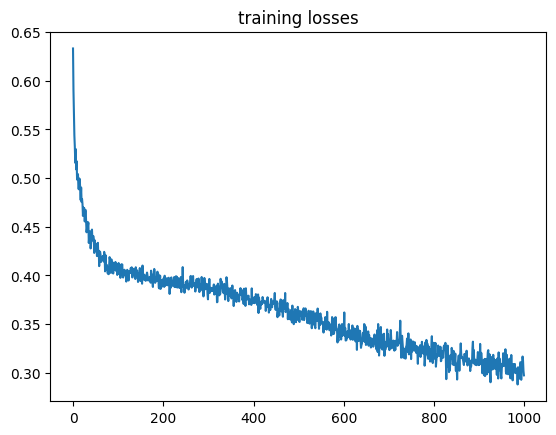

In [13]:
training_losses = train_loop(
    model,
    optimizer,
    vocab_size,
    train_loader,
    [train_loader, val_loader],
    max_iters,
    eval_interval,
    eval_iters,
)

print("training is done!")

plt.title("training losses")
plt.plot(training_losses)
plt.savefig("training_losses.png")

idx = torch.zeros((1, 1), dtype=torch.long, device=device)
print(tokenizer.decode(model.generate(idx, max_new_tokens=500)[0].tolist()))

model_params = {
    "params": {
    "vocab_size": vocab_size,
    "block_size": block_size,
    "n_embd": n_embd,
    "n_head": n_head,
    "n_blocks": n_blocks,
    "dropout": dropout,
    "device": device,
    }
}

save(model, tokenizer, model_params, "model")

print("-" * 50)
print("The experiment is going to start soon!")

# configurations = get_config_combinations()[:-2]
configurations = [
    [
        ("width_head", 0.2),
        ("width_neuron", 0.2),
        ("width_embedding", 0.2),
    ]
]


results = experiment(
    batch_size,
    block_size,
    vocab_size,
    calibration_loader,
    val_loader,
    device=device,
    pruning_strategies=configurations,
    learning_rate=learning_rate,
    model_path="./model",
)